In [3]:
from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools, AllChem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

import os
import seaborn as sns
sns.set(style ='darkgrid')


#from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams


from rdkit import Chem, DataStructs
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys,
    rdFingerprintGenerator,)


df = pd.read_csv("Data_apelin.csv", index_col=None)
df.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [5]:
os.chdir('/home/labhhc/Documents/Project/CADD_package/utility')
from standardize import standardization

from rdkit.rdBase import BlockLogs
block = BlockLogs()
std = standardization(data=df,ID='ID', smiles_col='Smiles', active_col='active', ro5 =4)
data = std.filter_data()
data.head(2)

reading NP model ...
model in


  0%|          | 0/53996 [00:00<?, ?it/s]

  0%|          | 0/26879 [00:00<?, ?it/s]

/home/labhhc/Documents/Project/CADD_package/utility/standardize.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Molecule'] = self.data['Canomicalsmiles'].progress_apply(self.standardize)


,Smiles,active,ID,Canomicalsmiles,Molecule
0,CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)NC(CC3CCCC3)C(=...,1,0,CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)NC(CC3CCCC3)C(=...,<rdkit.Chem.rdchem.Mol object at 0x7f2fbf2b6c10>
1,CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)NC(CC3CCC3)C(=O...,1,0,CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)NC(CC3CCC3)C(=O...,<rdkit.Chem.rdchem.Mol object at 0x7f2fbf2b6f90>


In [10]:
os.chdir('/home/labhhc/Documents/Project/CADD_package/similarity/Test')
active_data = pd.read_csv('active_apelin.csv')
active_data.drop(["Unnamed: 0"], axis = 1, inplace = True)
active_data.rename(columns ={'StandSmiles':'Smiles'}, inplace = True)
active_data['active'] = np.zeros(len(active_data))

block = BlockLogs()
std = standardization(data=active_data,ID='ID', smiles_col='Smiles', active_col='active', ro5 =4)
active_data = std.filter_data()
active_data.head(2)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/home/labhhc/Documents/Project/CADD_package/utility/standardize.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Molecule'] = self.data['Canomicalsmiles'].progress_apply(self.standardize)


,ID,Smiles,active,Canomicalsmiles,Molecule
0,US9156796B2_95,CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)N[C@H](CC(=O)O)...,0.0,CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)N[C@H](CC(=O)O)...,<rdkit.Chem.rdchem.Mol object at 0x7f2fbd6759e0>
2,WO2017096130A1_58,COc1cccc(OC)c1-n1c(COC(C)C)nc(=O)c(Cc2ccc(-n3c...,0.0,COc1cccc(OC)c1-n1c(COC(C)C)nc(=O)c(Cc2ccc(-n3c...,<rdkit.Chem.rdchem.Mol object at 0x7f2fbd675970>


In [11]:
idx =[]
for key, values in enumerate(data.ID):
    if values in active_data.ID.to_list():
        idx.append(key)
data.drop(idx, axis =0, inplace =True)

/tmp/ipykernel_3265139/2633587648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(idx, axis =0, inplace =True)


In [36]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import average_precision_score

class Similarity:
    """""
    Input:
    - active_data: dataframe
        dataframe with active compounds for similarity searching
    - data: dataframe
        dataframe for validation
    - mol_col: string
        name of mol column
    - active_col: string
        name of bioactive column ~ pIC50
    
    Return:
    -
    """""
    def __init__(self,active_data, data, mol_col, active, ID):
        self.active_data = active_data
        self.data = data
        self.mol_col = mol_col
        self.active = active
        self.ID = ID
    
    def mol2ecfp(self, mol):
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits = 2048)
            ar = np.zeros((1,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp, ar)
            return ar
        
    def mol2fp(self):
        self.fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits = 2048) 
                             for mol in self.data[self.mol_col]]
    
     
    
    def plot_roc (self, y_test, y_score, model):
        """ Calculates and plots and ROC and AUC.
        Parameters:
        actives_list - binary array of active/decoy status.
        score_list - array of experimental scores.
        """
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = round(auc(fpr, tpr),3)
        # Plot figure
        #sns.set('notebook', 'whitegrid', 'dark', font_scale=1.5, font='Ricty',
        #rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
        #plt.figure(figsize = (12,8))
        lw = 2
        plt.plot(fpr, tpr, 
                 lw=lw, label=f'{model} (AUC = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize = 18)
        plt.ylabel('True Positive Rate', fontsize = 18)
        plt.title('Receiver operating characteristic', fontsize = 36, weight = 'semibold')
        plt.legend(loc="lower right")
        
        
    def plot_ap(self, y_test, y_score, model):
        """ Calculates and plots and ROC and AUC.
        Parameters:
        actives_list - binary array of active/decoy status.
        score_list - array of experimental scores.
        """
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
        lw = 2
        plt.plot(recall, precision, 
                 lw=lw, label=f'{model} (AP = %0.3f)' % ap)
        plt.plot([0, 0], [0, 0], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Rrecision', fontsize = 18)
        plt.ylabel('Recall', fontsize = 18)
        plt.title('Precision Recall curve', fontsize = 36, weight = 'semibold')
        plt.legend(loc="lower right")
        
    def similarity_validate(self):
        self.mol2fp()
        plt.figure(figsize=(12,8))
        for i, j in enumerate(self.active_data[self.mol_col]):
            fp = AllChem.GetMorganFingerprintAsBitVect(j, radius=2, nBits = 2048)
            self.data["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(fp, self.fingerprints)
            
            self.plot_roc(self.data[self.active], self.data["tanimoto_morgan"], model = self.active_data.iloc[i,:].ID)
            
            
            #self.plot_ap(self.data[self.active], self.data["tanimoto_morgan"], model = self.active_data.iloc[i,:].ID)
        
    
    def ensemble_fp(self):
        
        # Ensemble

     
        self.active_data['fp'] = self.active_data[self.mol_col].apply(self.mol2ecfp)
        X = np.stack(self.active_data['fp'])
        self.df_ensemble = pd.DataFrame()
        
        for i in range(X.shape[0]):
            en_fp = X.sum(axis = 0)
            en_fp[en_fp > i] = 1

            arr_tostring = "".join(en_fp.astype(str))
            arr_tostring

            # Chuyển string của 0, 1 thành ExplicitVBitVect, cái này cũng dùng cho tanimoto được luôn
            EBitVect = DataStructs.cDataStructs.CreateFromBitString(arr_tostring)
            df_EBitVect = pd.DataFrame([EBitVect])
            df_EBitVect.columns = [f'Ensemble_{i}']
            self.df_ensemble = pd.concat([self.df_ensemble,df_EBitVect.T], axis=0)
        
        self.df_ensemble.columns = ['Ensemble method']
        self.df_ensemble['ID'] = self.df_ensemble.index
        
    
    def similarity_ensemble(self):
        self.mol2fp()
        plt.figure(figsize=(12,8))
        for i, j in enumerate(self.df_ensemble['Ensemble method']):
            self.data["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(j, self.fingerprints)
            self.plot_ap(self.data[self.active], self.data['tanimoto_morgan'], model = self.df_ensemble.iloc[i,:].ID)
            
        for i, j in enumerate(self.df_ensemble['Ensemble method']):
            self.data["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(j, self.fingerprints)
            self.plot_roc(self.data[self.active], self.data['tanimoto_morgan'], model = self.df_ensemble.iloc[i,:].ID)

/tmp/ipykernel_3265139/1745057946.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(fp, self.fingerprints)
/tmp/ipykernel_3265139/1745057946.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(fp, self.fingerprints)
/tmp/ipykernel_3265139/1745057946.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

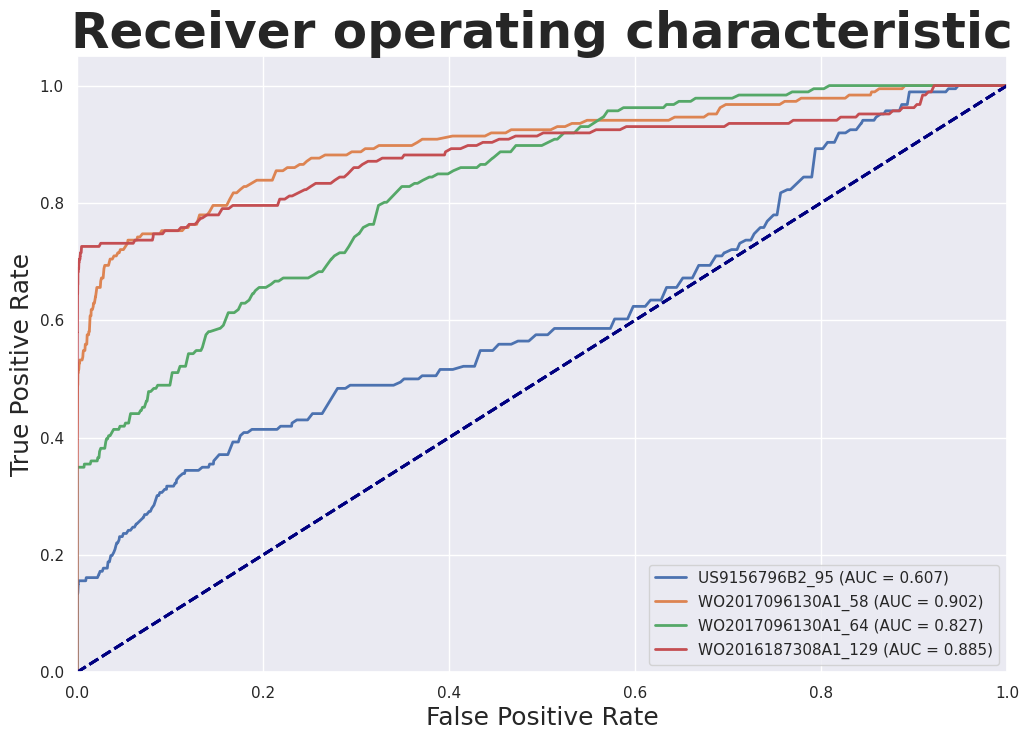

In [37]:
Simi = Similarity(active_data=active_data.iloc[:,:], data=data, mol_col='Molecule', active='active', ID='ID')
Simi.similarity_validate()

/tmp/ipykernel_3265139/1745057946.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(j, self.fingerprints)
/tmp/ipykernel_3265139/1745057946.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(j, self.fingerprints)
/tmp/ipykernel_3265139/1745057946.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

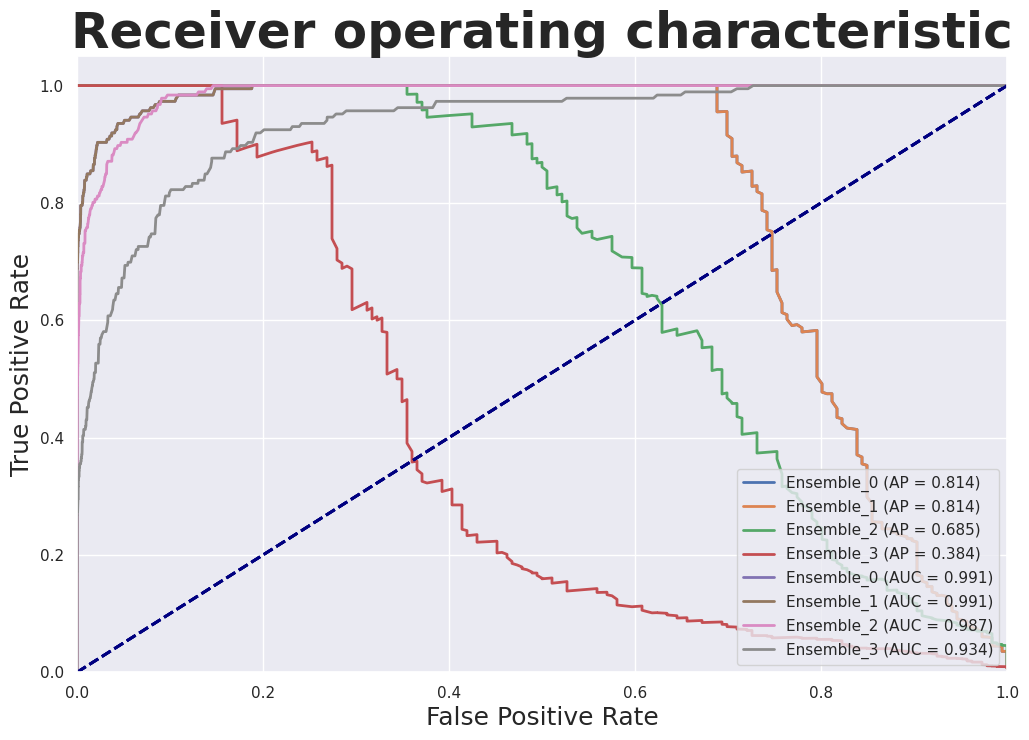

In [38]:
Simi.ensemble_fp()
Simi.similarity_ensemble()

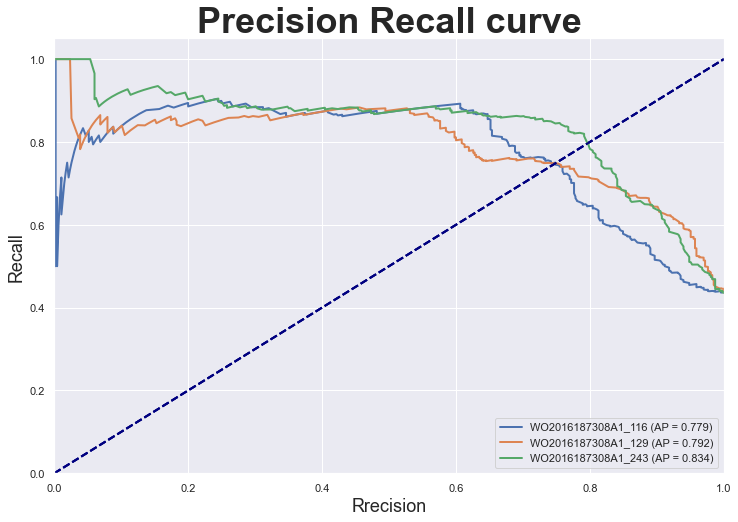

In [100]:
Simi = Similarity(active_data=active_data.iloc[-3:,:], data=data, mol_col='ROMol', active='active', ID='ID')
Simi.similarity_validate()

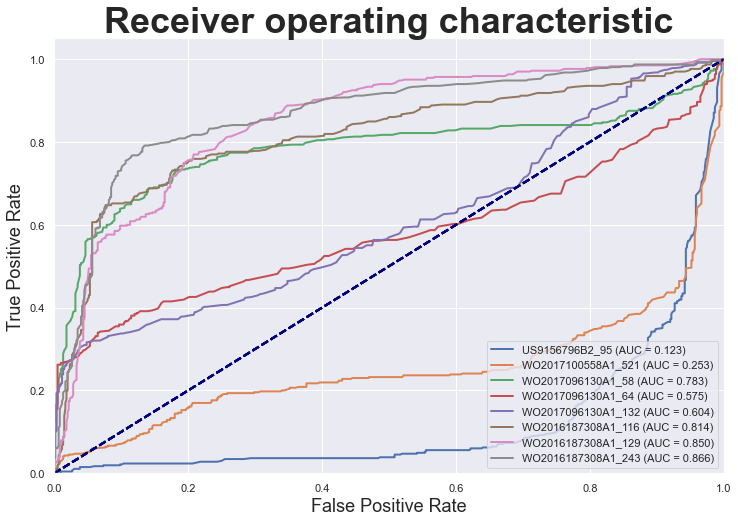

In [90]:
Simi = Similarity(active_data=active_data, data=data, mol_col='ROMol', active='active', ID='ID')
Simi.similarity_validate()

In [ ]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()